In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        continue
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Exploration

## Understanding how the labels look

In [2]:
from glob import glob

In [4]:
# Path to train_annotations folder
annotation_path = "/kaggle/input/MABe-mouse-behavior-detection/train_annotation/"

# Selecting one parquet file from any subfolder
parquet_files = glob(os.path.join(annotation_path, "*/*.parquet"))

# Loading the first one
sample_file = parquet_files[0]
print("Loading: ", sample_file)

df = pd.read_parquet(sample_file)
print(df.head())

Loading:  /kaggle/input/MABe-mouse-behavior-detection/train_annotation/CRIM13/1763467574.parquet
   agent_id  target_id  action  start_frame  stop_frame
0         1          2  attack         1752        1846
1         1          2   sniff         1847        1912
2         1          2  attack         1913        1922
3         1          2  attack         1936        2124
4         1          2  attack         2157        2164


**Context:**

* `agent_id`: the mouse doing the action (attacking or sniffing)
* `target_id`: the mouse receiving the action
* `start_frame`-`stop_frame`: the time span (in frames) during which that action occurs


## Understanding tracking (pose) data

In [5]:
# Path to pose data
tracking_path = "/kaggle/input/MABe-mouse-behavior-detection/train_tracking/"

# Selecting one tracking file from any subfolder
tracking_files = glob(os.path.join(tracking_path, "*/*.parquet"))

# Loading the first one
tracking_sampleFile = tracking_files[0]
print("Loading: ", tracking_sampleFile)

tracking_df = pd.read_parquet(tracking_sampleFile)
print(tracking_df.head())

Loading:  /kaggle/input/MABe-mouse-behavior-detection/train_tracking/CRIM13/1763467574.parquet
   video_frame  mouse_id   bodypart           x           y
0         1752         1   ear_left  122.905281  235.934219
1         1752         1  ear_right   98.905281  220.934219
2         1752         1   hip_left  133.905273  284.934235
3         1752         1  hip_right   88.905281  278.934235
4         1752         1       neck  106.905281  237.934219


**Context:**
* At **frame 1752, mouse 1** had those keypoint positions.
* Each bodypart (like hip_left, ear_right, neck, etc.) has (x, y) pixel coordinates

## Visualizing the pose for one mouse in one frame

In [6]:
import matplotlib.pyplot as plt

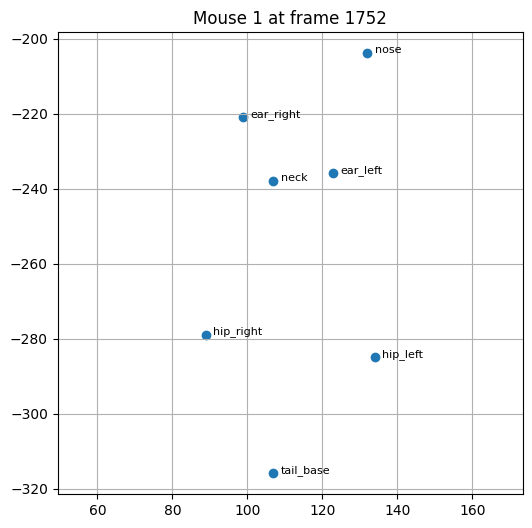

In [7]:
# Picking a specific frame and mouse
frame_to_plot = 1752
mouse_to_plot = 1

# Filter to that frame and mouse
pose_df = tracking_df[(tracking_df['video_frame'] == frame_to_plot) &
                    (tracking_df['mouse_id'] == mouse_to_plot)]

# Plot
plt.figure(figsize=(6,6))
plt.scatter(pose_df['x'], -pose_df['y'],
           label='keypoints')

# Annotate each point with bodypart name
for _, row in pose_df.iterrows():
    plt.text(row['x'] + 2, -row['y'], row['bodypart'], fontsize=8)

plt.title(f"Mouse {mouse_to_plot} at frame {frame_to_plot}")
plt.axis("equal")
plt.grid(True)
plt.show()

## Connecting keypoints (stick figure skeleton)

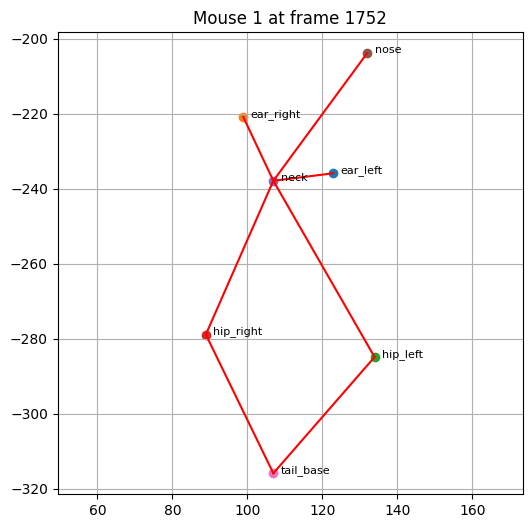

In [8]:
# Similar filtering
pose_df = tracking_df[(tracking_df['video_frame'] == frame_to_plot) &
                      (tracking_df['mouse_id'] == mouse_to_plot)]

# Creating lookup of bodypart (x, y)
points = {
    row['bodypart']: (row['x'], row['y']) for _, row in pose_df.iterrows()
}

# Draw
plt.figure(figsize=(6,6))
for part, (x,y) in points.items():
    plt.scatter(x, -y)
    plt.text(x + 2, -y, part, fontsize=8)

# Stick connections
connections = [
    ('nose', 'neck'),
    ('neck', 'hip_left'),
    ('neck', 'hip_right'),
    ('hip_left', 'tail_base'),
    ('hip_right', 'tail_base'),
    ('neck', 'ear_left'),
    ('neck', 'ear_right'),
]

for a, b in connections:
    if a in points and b in points:
        x1, y1 = points[a]
        x2, y2 = points[b]
        plt.plot([x1, x2], [-y1, -y2], color='red')

plt.title(f"Mouse {mouse_to_plot} at frame {frame_to_plot}")
plt.axis("equal")
plt.grid(True)
plt.show()

## Animating 10 frames of one mouse's skeleton

In [16]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [17]:
# Selecting the mouse and frame range
mouse_id = 1
start_frame = 1752
num_frames = 10
frames = list(range(start_frame, start_frame + num_frames))

# Filtering tracking data for these frames
sub_df = tracking_df[
(tracking_df['mouse_id'] == mouse_id) &
(tracking_df['video_frame'].isin(frames))
]

# Set up the plot
fig, ax = plt.subplots(figsize=(6,6))
scatter_pts = ax.scatter([], [], s=50)
lines = []

# Using the same connections list as above
for _ in connections:
    line, = ax.plot([], 'r-', lw=2)
    lines.append(line)

text_labels = []

def init():
    ax.set_xlim(50, 180)
    ax.set_ylim(-375, -190)
    ax.set_title(f"Mouse {mouse_id} movement")
    return [scatter_pts] + lines + text_labels

def update(frame_num):
    frame = frames[frame_num]
    pose = sub_df[sub_df['video_frame'] == frame]

    xs = pose['x'].values
    ys = -pose['y'].values
    scatter_pts.set_offsets(list(zip(xs, ys)))

    # Line updates
    points = {row['bodypart']: (row['x'], -row['y']) for _, row in pose.iterrows()}
    for i, (a, b) in enumerate(connections):
        if a in points and b in points:
            x1, y1 = points[a]
            x2, y2 = points[b]
            lines[i].set_data([x1, x2], [y1, y2])

        else:
            lines[i].set_data([], [])

    return [scatter_pts] + lines

anim = FuncAnimation(fig, update, frames=len(frames), init_func=init,
                    blit = True)
plt.close()
HTML(anim.to_jshtml())

## Overlay two mice (agent + target) during a labeled behavior

In [18]:
# Loading a behavior annotation file
annotation_df = pd.read_parquet(sample_file)

# Get first 'attack' entry
attack_row = annotation_df[annotation_df['action'] == 'attack'].iloc[0]
agent_id = attack_row['agent_id']
target_id = attack_row['target_id']
attack_frame = attack_row['start_frame']

print(f"Attack at frame {attack_frame} between agent {agent_id} and target {target_id}")

Attack at frame 1752 between agent 1 and target 2


In [19]:
# # Filter both mice at the frame
frame_df = tracking_df[
(tracking_df['video_frame'] == attack_frame) &
(tracking_df['mouse_id'].isin([agent_id, target_id]))
]

print(frame_df)

    video_frame  mouse_id   bodypart           x           y
0          1752         1   ear_left  122.905281  235.934219
1          1752         1  ear_right   98.905281  220.934219
2          1752         1   hip_left  133.905273  284.934235
3          1752         1  hip_right   88.905281  278.934235
4          1752         1       neck  106.905281  237.934219
5          1752         1       nose  131.905273  203.934219
6          1752         1  tail_base  106.905281  315.934235
7          1752         2   ear_left  157.657959  284.892181
8          1752         2  ear_right  199.657959  276.892181
9          1752         2   hip_left  142.657959  221.892166
10         1752         2  hip_right  188.657959  197.892166
11         1752         2       neck  179.657959  266.892181
12         1752         2       nose  182.657959  311.892181
13         1752         2  tail_base  139.657959  181.892166


## Placing both mice in the same frame

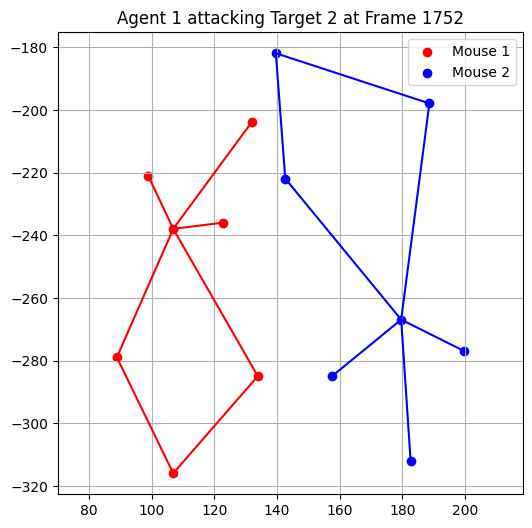

In [20]:
# Using the same connections list as the above

colors = {agent_id: 'red', target_id: 'blue'}
plt.figure(figsize=(6,6))

for mouse in [agent_id, target_id]:
    mouse_df = frame_df[frame_df['mouse_id'] == mouse]
    points = {row['bodypart']: (row['x'], -row['y']) for _, row in mouse_df.iterrows()}

    # Draw keypoints
    xs = [x for x, y in points.values()]
    ys = [y for x, y in points.values()]
    plt.scatter(xs, ys, label=f"Mouse {mouse}", color=colors[mouse])

    # Draw lines
    for a, b in connections:
        if a in points and b in points:
            x1, y1 = points[a]
            x2, y2 = points[b]
            plt.plot([x1, x2], [y1, y2], color=colors[mouse])

plt.title(f"Agent {agent_id} attacking Target {target_id} at Frame {attack_frame}")
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

## Animating Agent + Target Skeletons

In [21]:
# Get full frame window
start_frame = attack_row['start_frame']
stop_frame = attack_row['stop_frame']
frame_range = list(range(start_frame, stop_frame + 1))

# Filter tracking data for both mice across frames
attack_df = tracking_df[
(tracking_df['mouse_id'].isin([agent_id, target_id])) &
(tracking_df['video_frame'].isin(frame_range))
]

# Using the same connections list as above

colors = {agent_id: 'red', target_id: 'blue'}

# Plot setup
fig, ax = plt.subplots(figsize=(12,12))
scatter_agent = ax.scatter([], [], color='red', label=f'Agent {agent_id}')
scatter_target = ax.scatter([], [], color='blue', label=f'Target {target_id}')
lines_agent = [ax.plot([], [], 'r-', lw=2)[0] for _ in connections]
lines_target = [ax.plot([], [], 'b-', lw=2)[0] for _ in connections]

ax.set_xlim(45, 700)
ax.set_ylim(-375, -150)
ax.set_title("Agent-Target Interaction")
ax.axis("equal")
ax.legend()
ax.grid(True)

def init():
    for line in lines_agent + lines_target:
        line.set_data([], [])
    return [scatter_agent, scatter_target] + lines_agent + lines_target

def update(frame_num):
    frame = frame_range[frame_num]
    pose = attack_df[attack_df['video_frame'] == frame]

    # Draw each mouse
    plots = []
    for mouse, scatter, lines in zip([agent_id, target_id],
                                     [scatter_agent, scatter_target],
                                     [lines_agent, lines_target]):
        mouse_df = pose[pose['mouse_id'] == mouse]
        points = {row['bodypart']: (row['x'], -row['y']) for _, row in mouse_df.iterrows()}

        xs = [x for x, y in points.values()]
        ys = [y for x, y in points.values()]
        scatter.set_offsets(list(zip(xs, ys)))

        for i, (a, b) in enumerate(connections):
            if a in points and b in points:
                x1, y1 = points[a]
                x2, y2 = points[b]
                lines[i].set_data([x1, x2], [y1, y2])
            else:
                lines[i].set_data([], [])

        plots += [scatter] + lines

    ax.set_title(f"Agent {agent_id} vs Target {target_id} | Frame {frame}")
    return plots

# Create the animation
anim = FuncAnimation(fig, update, frames=len(frame_range), init_func=init, blit=True)
plt.close()
HTML(anim.to_jshtml())

In [2]:
# Loading the files
import pandas as pd
import numpy as np

# File ID
file_id = "1763467574"

# Loading the train_tracking and train_annotation files for a particular video
track_file = f"/kaggle/input/MABe-mouse-behavior-detection/train_tracking/CRIM13/{file_id}.parquet"
annon_file = f"/kaggle/input/MABe-mouse-behavior-detection/train_annotation/CRIM13/{file_id}.parquet"

track_df = pd.read_parquet(track_file)
annon_df = pd.read_parquet(annon_file)

print("Tracking shape: ", track_df.shape)
print("Annonation shape: ", annon_df.shape)

Tracking shape:  (232694, 5)
Annonation shape:  (122, 5)


## Focusing on "attack" behaviors only

In [3]:
# Binary Classification - 1: attack and 0: not attack
attack_df = annon_df[annon_df["action"] == 'attack'].copy()

# Adding a column to mark each frame in the attack bout
attack_frames = set()
for _, row in attack_df.iterrows():
    attack_frames.update(range(row['start_frame'], row['stop_frame'] + 1))

print(f"Number of frames with attack behavior: {len(attack_frames)}")

Number of frames with attack behavior: 1599


## Feature Extraction (one frame at a time)

Extracting features for each frame where both agent and target are present

In [4]:
feature_rows = []

# Pick 1 agent-target pair from the attack annotation
row = attack_df.iloc[0]
agent_id = row['agent_id']
target_id = row['target_id']

# Adding additional features to be considered
prev_nose_a = None
prev_frame = None
prev_vec_body = None
prev_velocity_agent = None

# Frame range to scan
frame_range = sorted(track_df['video_frame'].unique())

In [5]:
# Go frame by frame
for frame in frame_range:
    frame_data = track_df[track_df['video_frame'] == frame]

    # Get agent and target pose
    agent = frame_data[frame_data['mouse_id'] == agent_id]
    target = frame_data[frame_data['mouse_id'] == target_id]

    if agent.empty or target.empty:
        continue  # if either mouse missing

    # Extract key points of interest
    def get_point(df, part):
        row = df[df['bodypart'] == part]
        if not row.empty:
            return np.array([row['x'].values[0], row['y'].values[0]])
        return None

    nose_a = get_point(agent, "nose")
    tail_t = get_point(target, "tail_base")
    nose_t = get_point(target, "nose")
    neck_a = get_point(agent, "neck")
    tail_a = get_point(agent, "tail_base")
    neck_t = get_point(target, "neck")

    # Check for missing data
    if any(x is None for x in [nose_a, tail_t, nose_t, neck_a, tail_a, neck_t]):
        continue

    # Basic geometric features
    nose_to_nose = np.linalg.norm(nose_a - nose_t)
    nose_to_tail = np.linalg.norm(nose_a - tail_t)
    vec_body = neck_a - tail_a
    body_orientation = np.degrees(np.arctan2(vec_body[1], vec_body[0]))
    center_agent = (neck_a + tail_a) / 2
    center_target = (neck_t + tail_t) / 2
    center_distance = np.linalg.norm(center_agent - center_target)
    nose_to_body = np.linalg.norm(nose_a - center_target)

    # Angle
    angle = np.degrees(np.arctan2(vec_body[1], vec_body[0]))

    # Compute angle change & angular velocity
    angle_change = None
    angular_velocity = None
    if prev_vec_body is not None and prev_frame is not None and frame != prev_frame:
        angle_prev = np.degrees(np.arctan2(prev_vec_body[1], prev_vec_body[0]))
        angle_diff = angle - angle_prev
        angle_change = angle_diff
        angular_velocity = angle_diff / (frame - prev_frame)

    # Velocity, acceleration, and velocity towards target
    velocity_agent = None
    acceleration_agent = None
    velocity_towards_target = None
    if prev_nose_a is not None and frame != prev_frame:
        movement_vector = nose_a - prev_nose_a
        velocity_agent = np.linalg.norm(movement_vector) / (frame - prev_frame)

        if prev_velocity_agent is not None:
            acceleration_agent = (velocity_agent - prev_velocity_agent) / (frame - prev_frame)

        if center_target is not None and np.linalg.norm(center_target - prev_nose_a) > 0:
            direction_to_target = center_target - prev_nose_a
            velocity_towards_target = np.dot(movement_vector, direction_to_target) / np.linalg.norm(direction_to_target)

    # Relative orientation
    relative_orientation = None
    direction_to_target = center_target - center_agent
    if np.linalg.norm(direction_to_target) > 0:
        angle_to_target = np.degrees(np.arctan2(direction_to_target[1], direction_to_target[0]))
        relative_orientation = angle_to_target - body_orientation

    # Save current state
    prev_nose_a = nose_a
    prev_vec_body = vec_body
    prev_velocity_agent = velocity_agent
    prev_frame = frame

    # Label
    label = int(frame in attack_frames)

    # Collect feature row
    feature_rows.append({
        "frame": frame,
        "nose_to_nose": nose_to_nose,
        "nose_to_tail": nose_to_tail,
        "body_orientation": body_orientation,
        "velocity_agent": velocity_agent,
        "center_distance": center_distance,
        "angle_change": angle_change,
        "nose_to_body": nose_to_body,
        "angular_velocity": angular_velocity,
        "acceleration_agent": acceleration_agent,
        "velocity_towards_target": velocity_towards_target,
        "relative_orientation": relative_orientation,
        "label": label
    })

# Create DataFrame
#df_features = pd.DataFrame(feature_rows)

print(f"Extracted features from {len(feature_rows)} frames")

Extracted features from 16621 frames


Feature Descriptions:
1. **nose_to_nose** - Euclidean distance between the noses of the agent and the target mice. It helps detect face-to-face confrontation.
2. **nose_to_tail** - Distance between agent's nose and the target's tail base. Useful for identifying chasing or rear-targeted behavior.
3. **body_orientation** - Angle of the agent's body bector from tail to neck. Indicates the facing direction of the agent.
4. **velocity_agent** - Speed of the agent's nose across consecutive frames. Helps identify whether the agent is rapidly approaching.
5. **center_distance** - Distance between the geometric centers (avg of neck + tail) of the agent and the target. It is more stable than nose-based distances.
6. **angle_change** - Change in the agent's body orientation angle between frames. Helps detect rapid turning, pivoting behavior, or chase initiation.
7. **nose_to_body** - Distance between the agent's nose and the center of the target's body. It is useful for gauging aimed behvior.
8. **velocity_towards_target** - Speed of the agent's nose directly toward the target's center (+ve: moving forward, -ve: moving away)
9. **relative_orientation** - Angle difference between agent's body orientation and directin to target.

## Converting it to a DatFrame

In [6]:
df_features = pd.DataFrame(feature_rows)
print(df_features.head())
print("Positive (attack) frames:", df_features['label'].sum())
#print(df_features.tail())

   frame  nose_to_nose  nose_to_tail  body_orientation  velocity_agent  \
0   1752    119.292732     23.365707        -90.000000             NaN   
1   1753    112.358757     29.235922        -88.567902        6.505515   
2   1754    107.001389     33.482372        -85.865326        4.519577   
3   1755    114.527740     27.391741        -78.558952        2.575784   
4   1756    111.276123     37.823891        -78.146988       10.400078   

   center_distance  angle_change  nose_to_body  angular_velocity  \
0        74.454765           NaN     34.478104               NaN   
1        82.385124      1.432098     29.238609          1.432098   
2        84.192612      2.702576     26.905775          2.702576   
3        90.803986      7.306374     33.379902          7.306374   
4        92.485107      0.411964     37.168724          0.411964   

   acceleration_agent  velocity_towards_target  relative_orientation  label  
0                 NaN                      NaN             45.114613

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


## Removing NaN values for modeling

In [7]:
print(df_features[df_features.isna().any(axis=1)].index.tolist())

[0, 1]


In [8]:
# Removing the row[0]
df_features = df_features.drop(index=[0,1])
print(df_features.isna().sum())

frame                      0
nose_to_nose               0
nose_to_tail               0
body_orientation           0
velocity_agent             0
center_distance            0
angle_change               0
nose_to_body               0
angular_velocity           0
acceleration_agent         0
velocity_towards_target    0
relative_orientation       0
label                      0
dtype: int64


In [9]:
# Resetting the index
df_features = df_features.reset_index(drop=True)

# Modeling

In [10]:
# train-test split
from sklearn.model_selection import train_test_split

In [11]:
# Split 80/20
X = df_features[["nose_to_nose", "nose_to_tail", "body_orientation", 
                 "velocity_agent", "center_distance", "angle_change", 
                 "nose_to_body", "acceleration_agent", "relative_orientation"]]
y = df_features["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=48)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 13295
Test size: 3324


## Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
# Class imbalance - balance
# Initialize model
clf = LogisticRegression(class_weight='balanced')

# Train
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report")
print(classification_report(y_test, y_pred, target_names=["Not Attack", "Attack"]))

Confusion Matrix:
[[2642  337]
 [  18  327]]

Classification Report
              precision    recall  f1-score   support

  Not Attack       0.99      0.89      0.94      2979
      Attack       0.49      0.95      0.65       345

    accuracy                           0.89      3324
   macro avg       0.74      0.92      0.79      3324
weighted avg       0.94      0.89      0.91      3324



Moving to other models due to logistic regression not being able to model nonlinear interactions such as "attack only happens if both nose_to_nose is small and body_orientation aligns".

### Saving the model

In [13]:
import joblib

# Save the model
joblib.dump(clf, 'logreg_baseline.pkl')

# Loading the saved model
model = joblib.load('logreg_baseline.pkl')

### Save predictions

In [14]:
import pandas as pd

# y_test is aligned with X_test
frames_test = df_features.loc[X_test.index, 'frame']

# Saving predictions to this file
preds_df = pd.DataFrame({
    'frame': frames_test.values,
    'true': y_test.values,
    'pred': y_pred
})
preds_df.to_csv("logreg_predictions.csv", index=False)

## Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(
    class_weight = 'balanced',
    n_estimators = 100, # change it 300 for stability
    max_depth = None,# maybe change it later to 10 (?)
    min_samples_leaf = 2,
    random_state = 42,
    n_jobs = 1
)

After hyperparameter tuning
* Added `min_samples_leaf=2` which:
  * Prevents the tree from splitting too early on noisy data.
  * Leads to slightly more generalized and robust trees.
  * Balances bias-variance tradeoff better in this case.

In [13]:
# Features being considered
# considering angular_velocity & velocity_towards_target which were not considered in LR
feature_cols = [
    "nose_to_nose", "nose_to_tail", "body_orientation",
    "velocity_agent", "center_distance", "angle_change",
    "nose_to_body", "acceleration_agent", "relative_orientation",
    "angular_velocity", "velocity_towards_target"
]

In [16]:
df_features

frame  nose_to_nose  nose_to_tail  body_orientation  velocity_agent  \
0       1754    107.001389     33.482372        -85.865326        4.519577   
1       1755    114.527740     27.391741        -78.558952        2.575784   
2       1756    111.276123     37.823891        -78.146988       10.400078   
3       1757    127.557884     57.592827        -79.019341       25.440367   
4       1758    120.809669     49.759930        -83.829819       12.634687   
...      ...           ...           ...               ...             ...   
16614  18368    120.218864     36.064522         19.692020       13.164752   
16615  18369     97.695122     52.467018         24.904768        8.428524   
16616  18370     82.111084     38.067924         36.732822       21.067591   
16617  18371     89.915207     21.899067         45.412189       28.142525   
16618  18372     57.383163     59.035374         52.594639       23.212990   

       center_distance  angle_change  nose_to_body  angular_velocity  \
0            84.192612      2.702576     26.905775          2.702576   
1            90.803986      7.306374     33.379902          7.306374   
2            92.485107      0.411964     37.168724          0.411964   
3           105.246262     -0.872353     61.793076         -0.872353   
4            99.823509     -4.810478     50.455444         -4.810478   
...                ...           ...           ...               ...   
16614       114.212669      4.976949     29.348927          4.976949   
16615       101.475746      5.212748     25.480196          5.212748   
16616       102.739014     11.828054     20.584440         11.828054   
16617        98.958511      8.679367     20.307770          8.679367   
16618       119.972908      7.182449     48.141983          7.182449   

       acceleration_agent  velocity_towards_target  relative_orientation  \
0               -1.985939                 3.276130             39.295612   
1               -1.943792                -1.432201             37.525845   
2                7.824293                 3.888394             44.467892   
3               15.040289               -23.192200             40.382099   
4              -12.805679                 5.767331             45.132610   
...                   ...                      ...                   ...   
16614            5.507726                12.980007              8.618395   
16615           -4.736228                 7.704138             12.969885   
16616           12.639067                21.002094             -3.124741   
16617            7.074934                25.228031            -13.268330   
16618           -4.929535                15.003862            -35.495258   

       label  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
16614      0  
16615      0  
16616      0  
16617      0  
16618      0  

[16619 rows x 13 columns]

In [14]:
#from sklearn.model_selection import train_test_split

X = df_features[feature_cols]
y = df_features["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   stratify=y, random_state=42)

print("Train Size:", len(X_train))
print("Test Size: ", len(X_test))

Train Size: 13295
Test Size:  3324


In [15]:
# Fit the model
clf_rf.fit(X_train, y_train)

# Predict
y_pred = clf_rf.predict(X_test)

print("Classification Report: \n ", classification_report(y_test, y_pred))
print("\nConfusion Matrix: ", confusion_matrix(y_test, y_pred))

Classification Report: 
                precision    recall  f1-score   support

           0       0.98      0.98      0.98      3005
           1       0.80      0.84      0.82       319

    accuracy                           0.96      3324
   macro avg       0.89      0.91      0.90      3324
weighted avg       0.97      0.96      0.97      3324


Confusion Matrix:  [[2940   65]
 [  52  267]]


### Saving the model

In [36]:
import joblib
joblib.dump(clf_rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

### Save predictions

In [37]:
import pandas as pd

# y_test is aligned with X_test
frames_test = df_features.loc[X_test.index, 'frame']

# Saving predictions to this file
preds_df = pd.DataFrame({
    'frame': frames_test.values,
    'true': y_test.values,
    'pred': y_pred
})
preds_df.to_csv("randomForest_predictions.csv", 
                index=False)

### Feature Importance Plot

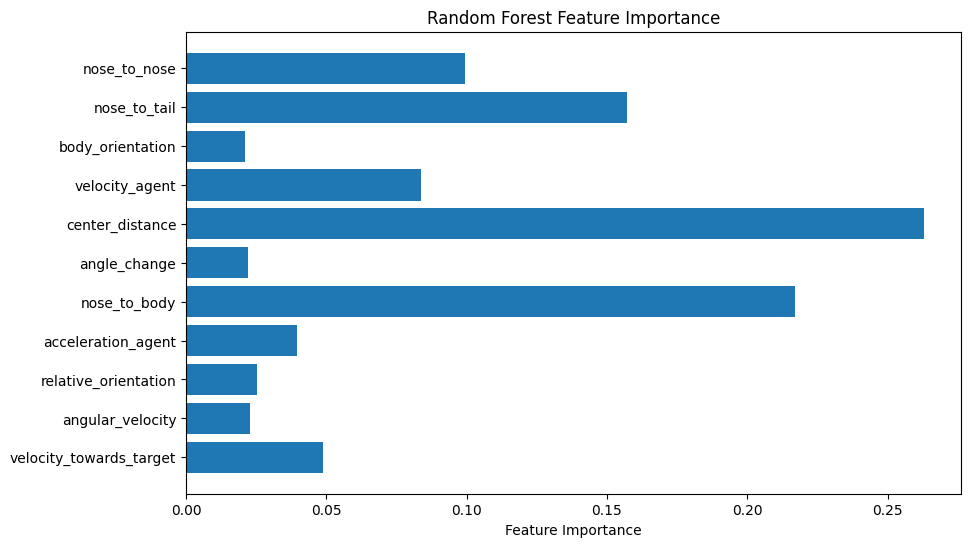

In [28]:
import matplotlib.pyplot as plt

importances = clf_rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(class_weight='balanced')
search = RandomizedSearchCV(rf, param_distributions=param_grid,
                            scoring='f1', n_iter=20, cv=5, verbose=1, n_jobs=-1)
search.fit(X_train, y_train)
best_model = search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [30]:
print(best_model)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       min_samples_leaf=2)


In [18]:
from sklearn.model_selection import cross_val_score

best_model = search.best_estimator_
scores = cross_val_score(best_model, X, y, cv=5, scoring='f1')
print(f"Cross-Validation F1 scores: {scores}")
print(f"Mean F1 score: {scores.mean():.4f}")

Cross-Validation F1 scores: [0.58449304 0.67479675 0.81178396 0.84868421 0.69522241]
Mean F1 score: 0.7230


### Interpretation:
1. Confirms that the model generalizes reasonably well when tested on unseen data.
2. But there is some variance between folds, which indicates that the model performance is sensitive to how the data is split (which is common in imbalance datasets)
3. The average F1 score is ~0.72 which is lower than the single test set F1 ~ 0.82, which is as expected (test scores are slightly overestimate performance)

## Stochastic Gradient Boosting (SGB)

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X = df_features[feature_cols]
y = df_features["label"]

# Spli the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

print("Train Size:", len(X_train))
print("Test Size: ", len(X_test))

Train Size: 13295
Test Size:  3324


In [16]:
# Split training into smaller train/val sets for early stopping
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2,
                                                         random_state=42)

print("Train Subsample: ", len(X_train_sub))
print("Test Subsample: ", len(X_val))

Train Subsample:  10636
Test Subsample:  2659


In [20]:
sgb = GradientBoostingClassifier(
    # incrementing manually
    n_estimators=1,
    learning_rate=1.0,
    max_depth=3,
    warm_start=True,
    subsample=0.8,
    random_state=42
)

# Early stopping
max_rounds = 100
patience = 5
best_score = -np.inf
best_model = None
rounds_no_improve = 0

val_score = []

for i in range(1, max_rounds + 1):
    sgb.n_estimators = i
    sgb.fit(X_train_sub, y_train_sub)

    y_val_pred = sgb.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average='macro')

    if f1 > best_score:
        best_score = f1
        rounds_no_improve = 0
        best_model = GradientBoostingClassifier(**sgb.get_params())
        best_model.fit(X_train_sub, y_train_sub)

    else:
        rounds_no_improve += 1

    if rounds_no_improve >= patience:
        print(f"Early stopping at iteration {i}. Best validation F1_macro: {best_score:.4f}")
        break

Early stopping at iteration 6. Best validation F1_macro: 0.8616


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate best model on final test set
y_test_pred = best_model.predict(X_test)
print("\nFinal Test Performance:")
print(classification_report(y_test, y_test_pred))


Final Test Performance:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      3007
           1       0.62      0.88      0.73       317

    accuracy                           0.94      3324
   macro avg       0.81      0.91      0.85      3324
weighted avg       0.95      0.94      0.94      3324



## XGBoost

In [23]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

xgb = XGBClassifier(
   scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    use_label_encoder=False,
    eval_metrics='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [21:33:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrics" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              eval_metrics='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [24]:
y_pred = xgb.predict(X_test)

In [25]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      3007
           1       0.78      0.85      0.81       317

    accuracy                           0.96      3324
   macro avg       0.88      0.91      0.90      3324
weighted avg       0.96      0.96      0.96      3324


Confusion Matrix:
 [[2929   78]
 [  46  271]]
